Total Rows: 205
Total Columns: 26
car_ID                int64
symboling             int64
CarName              object
fueltype             object
aspiration           object
doornumber           object
carbody              object
drivewheel           object
enginelocation       object
wheelbase           float64
carlength           float64
carwidth            float64
carheight           float64
curbweight            int64
enginetype           object
cylindernumber       object
enginesize            int64
fuelsystem           object
boreratio           float64
stroke              float64
compressionratio    float64
horsepower            int64
peakrpm               int64
citympg               int64
highwaympg            int64
price               float64
dtype: object
Categorical Columns:
['fueltype', 'aspiration', 'doornumber', 'carbody', 'drivewheel', 'enginelocation', 'enginetype', 'cylindernumber', 'fuelsystem', 'CompanyName']

Numerical Columns:
['car_ID', 'symboling', 'wheelbase', '

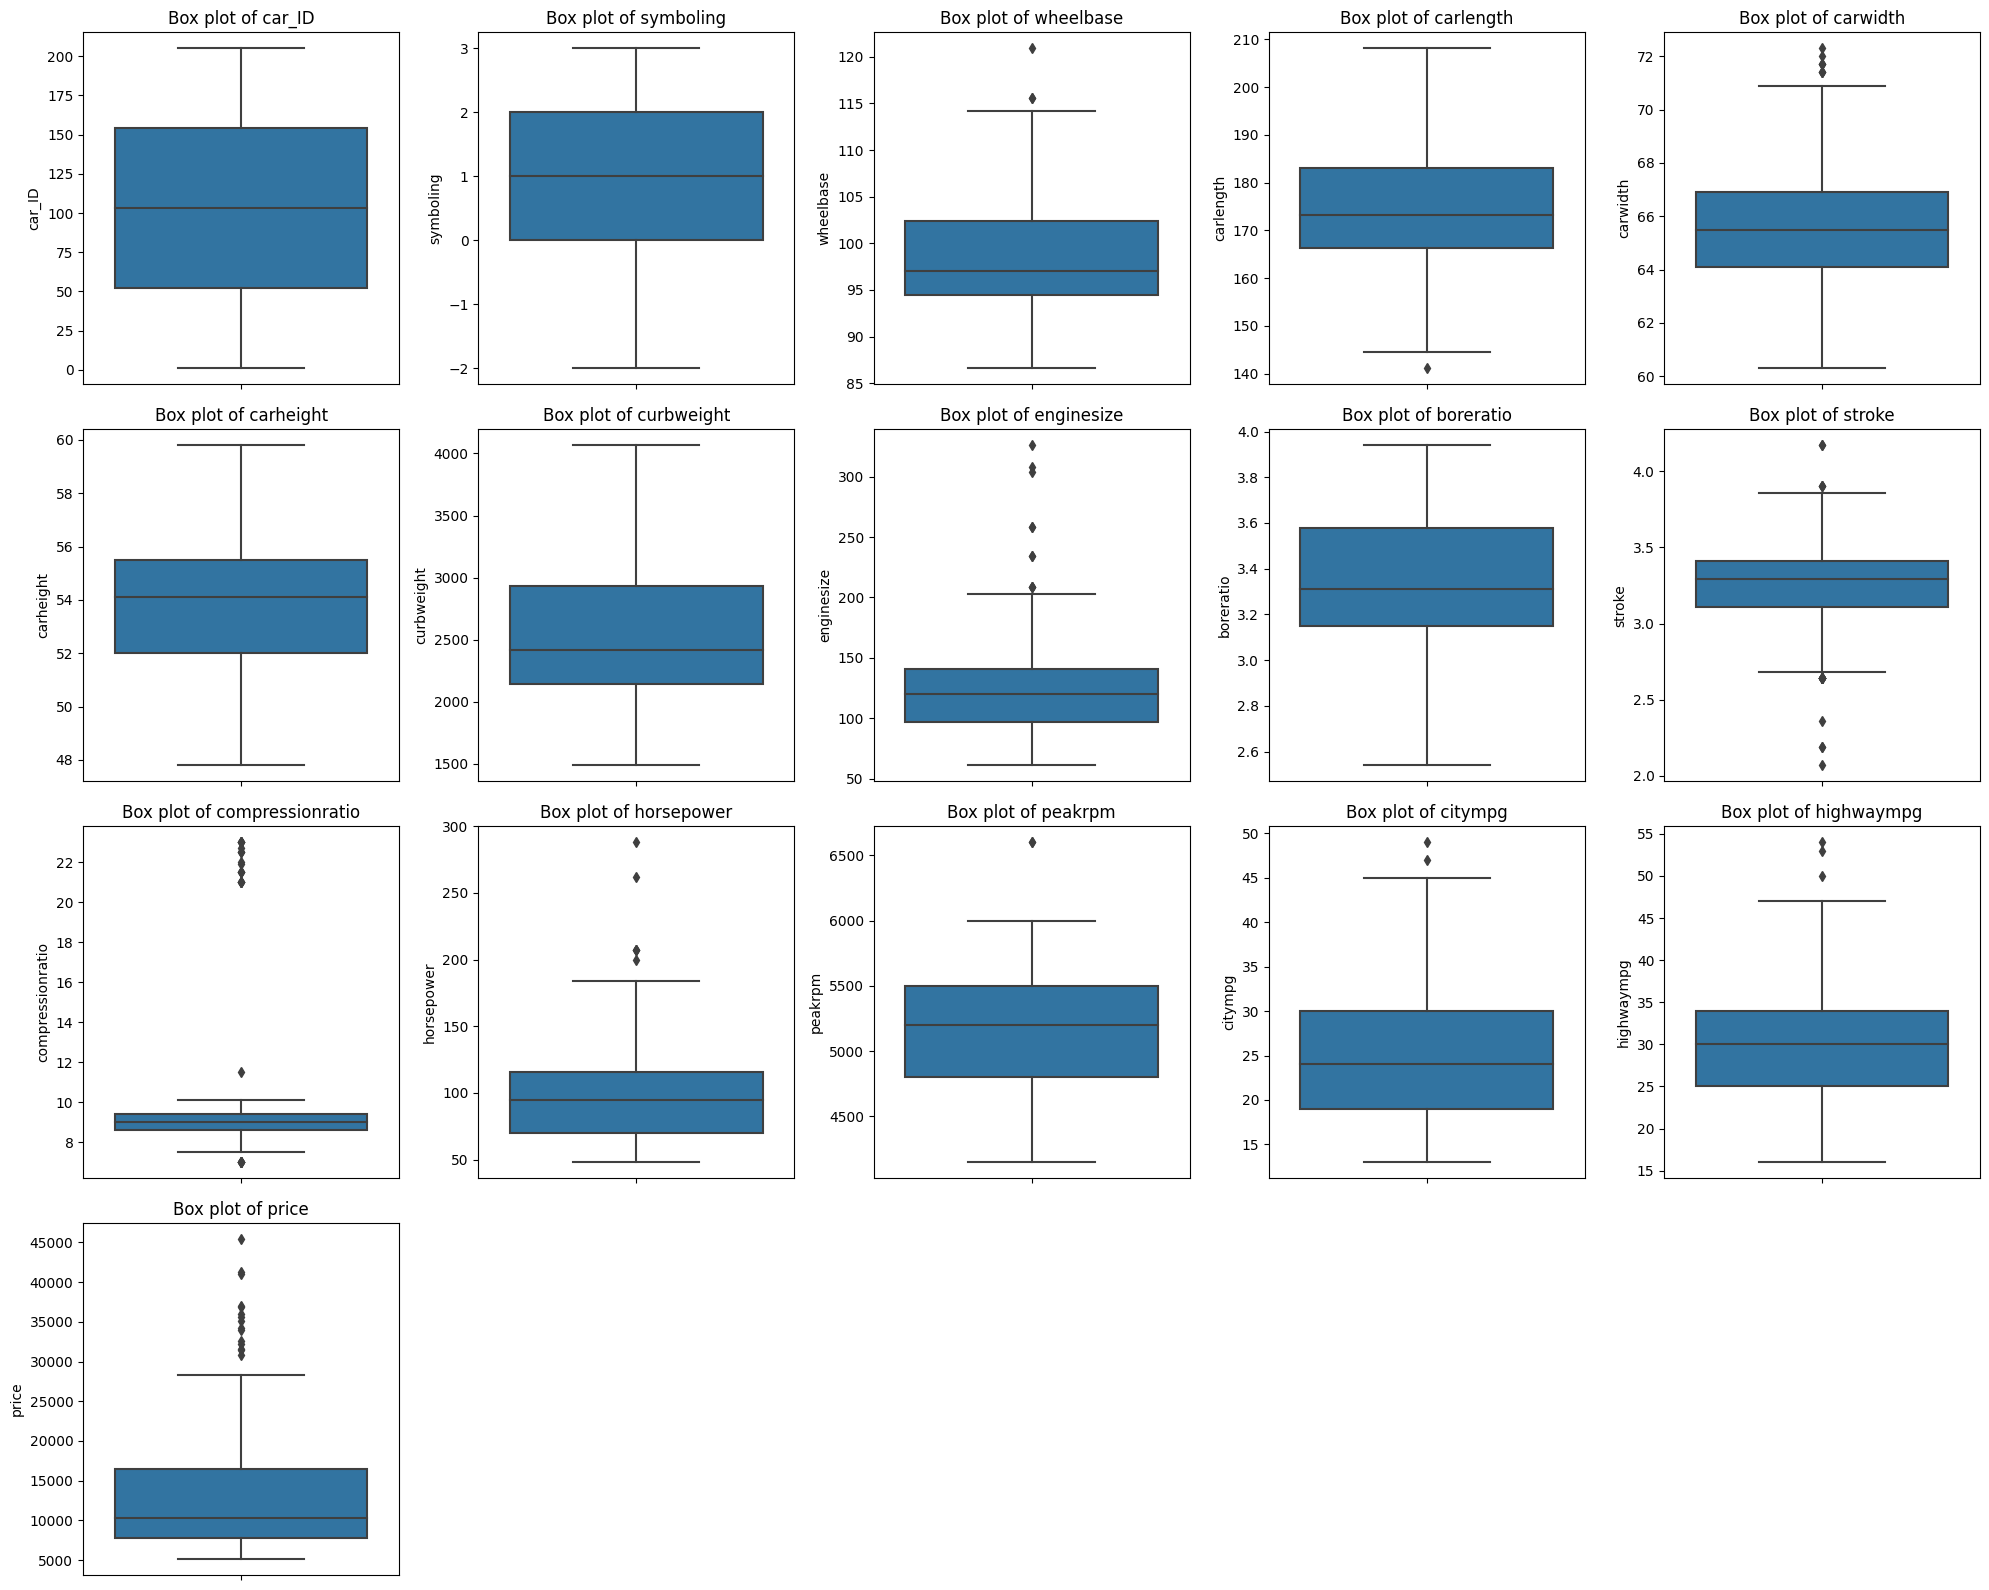

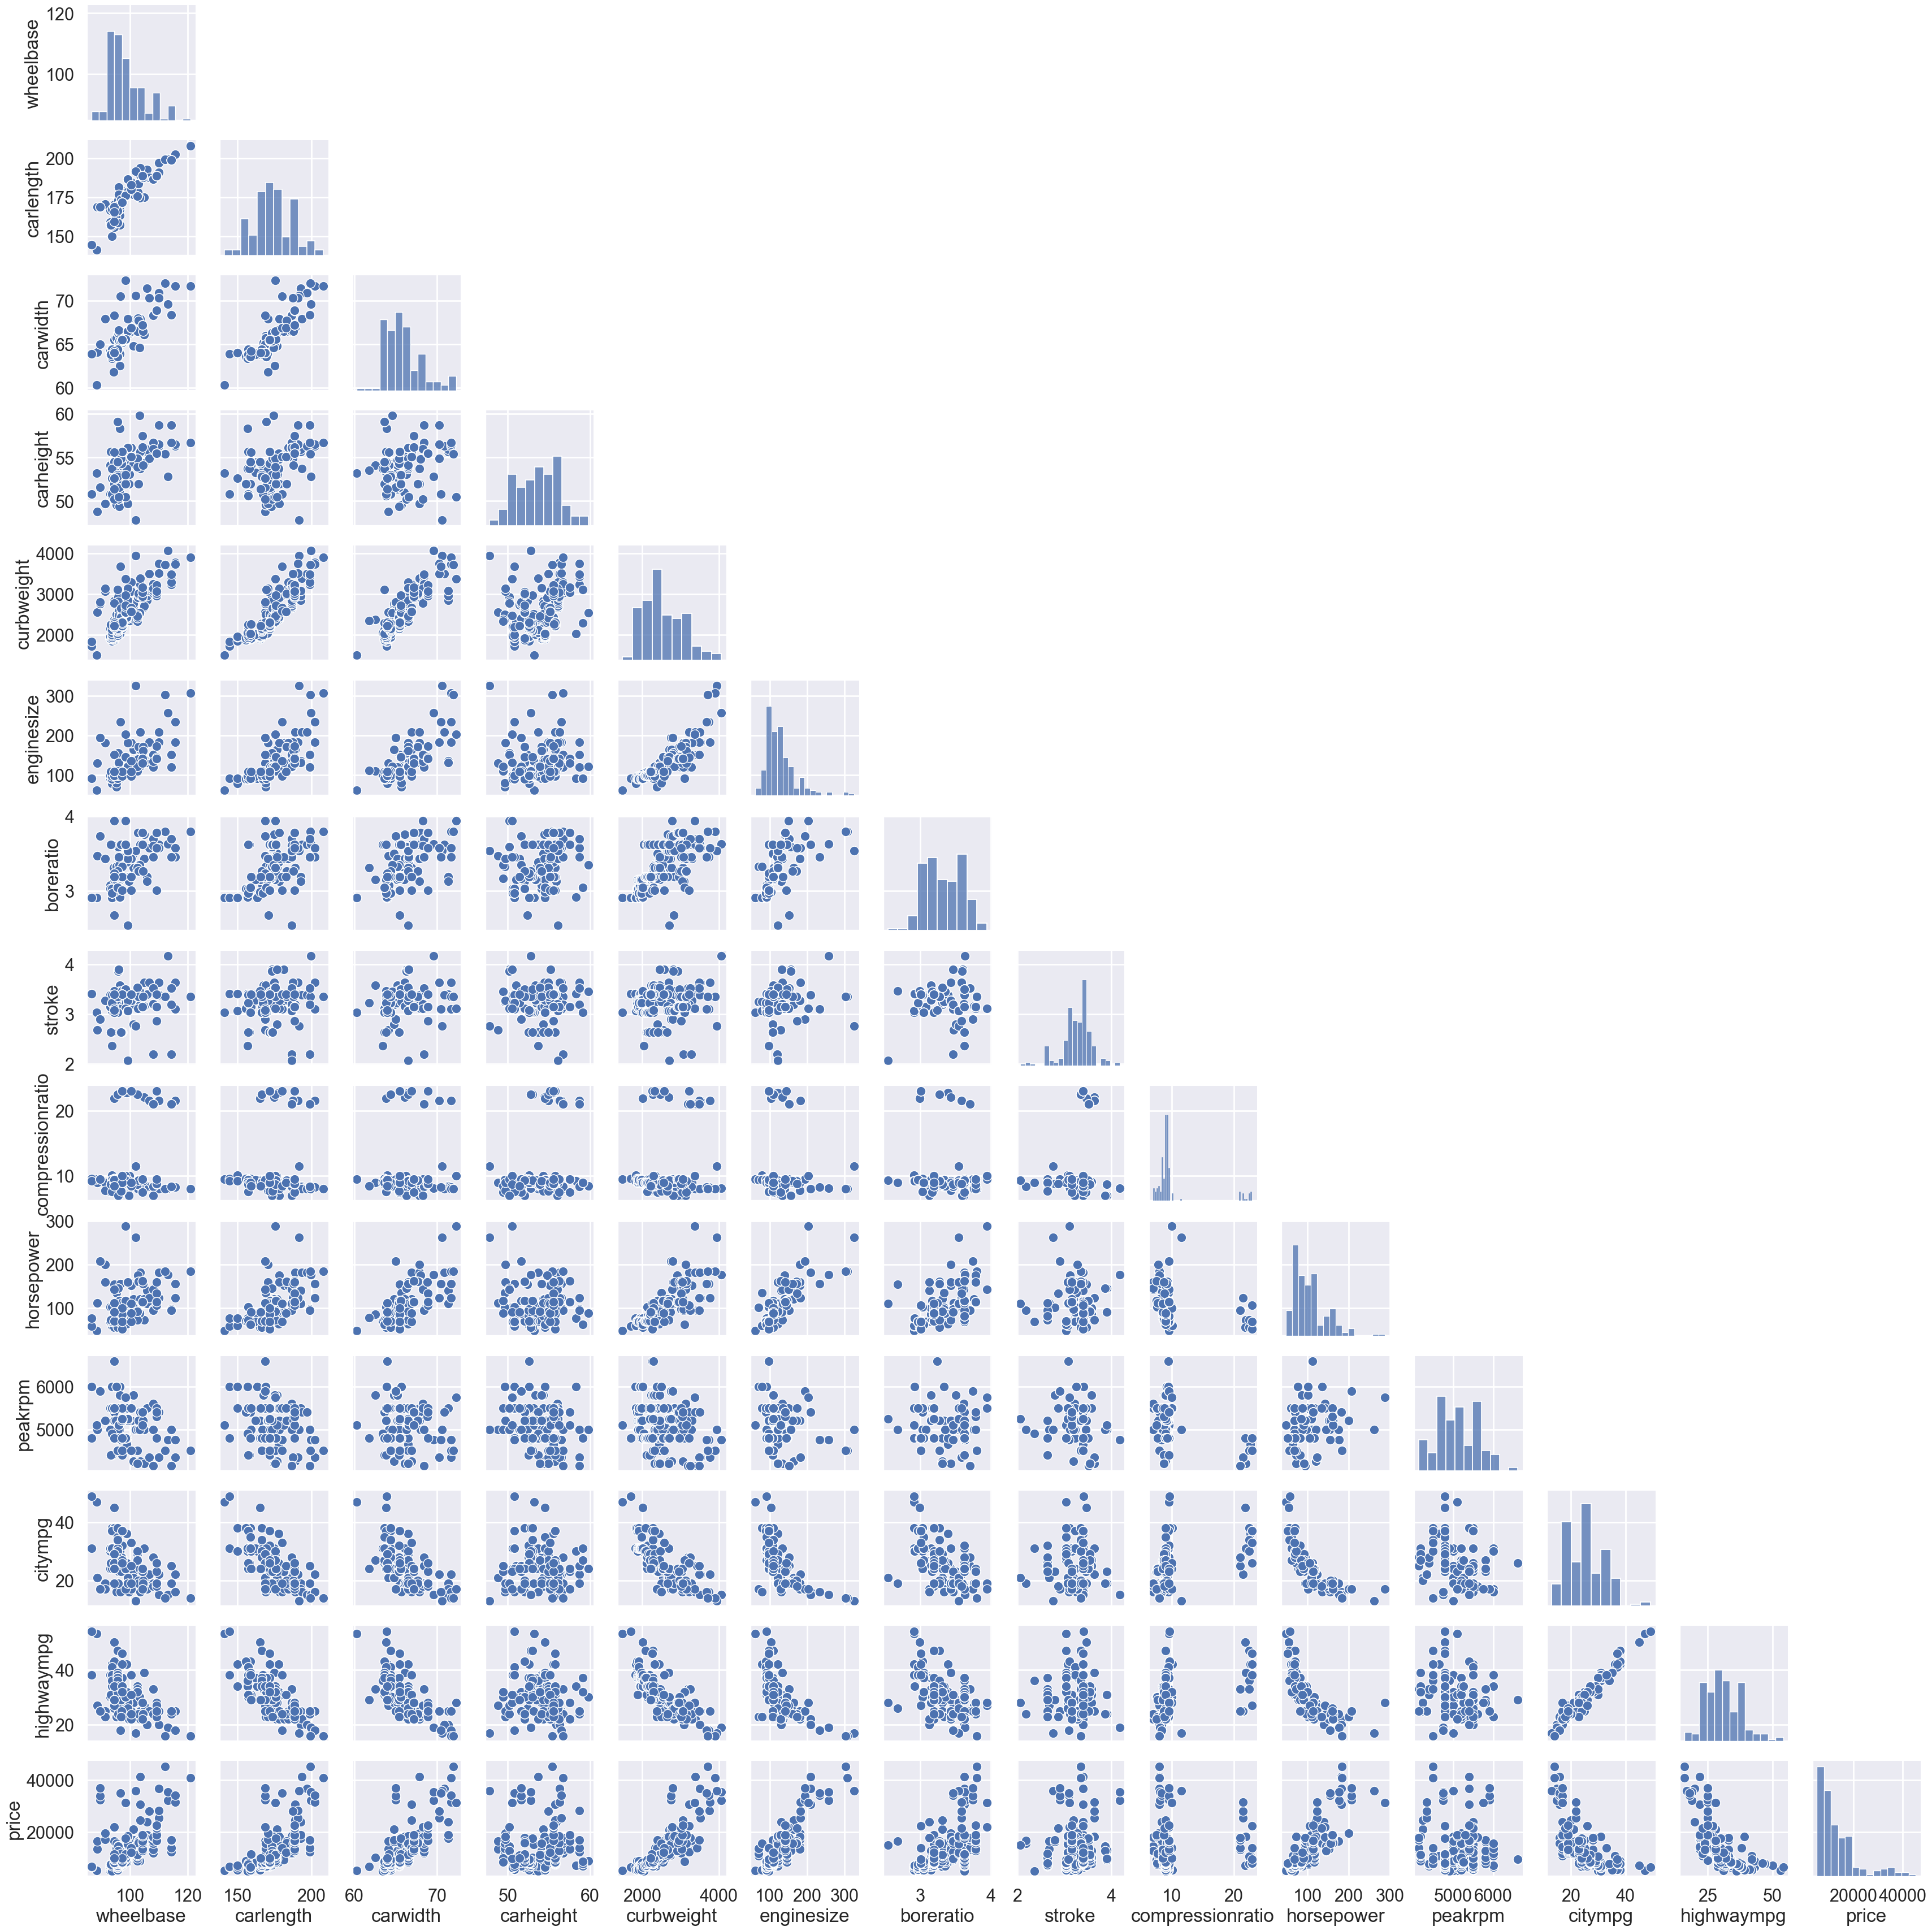

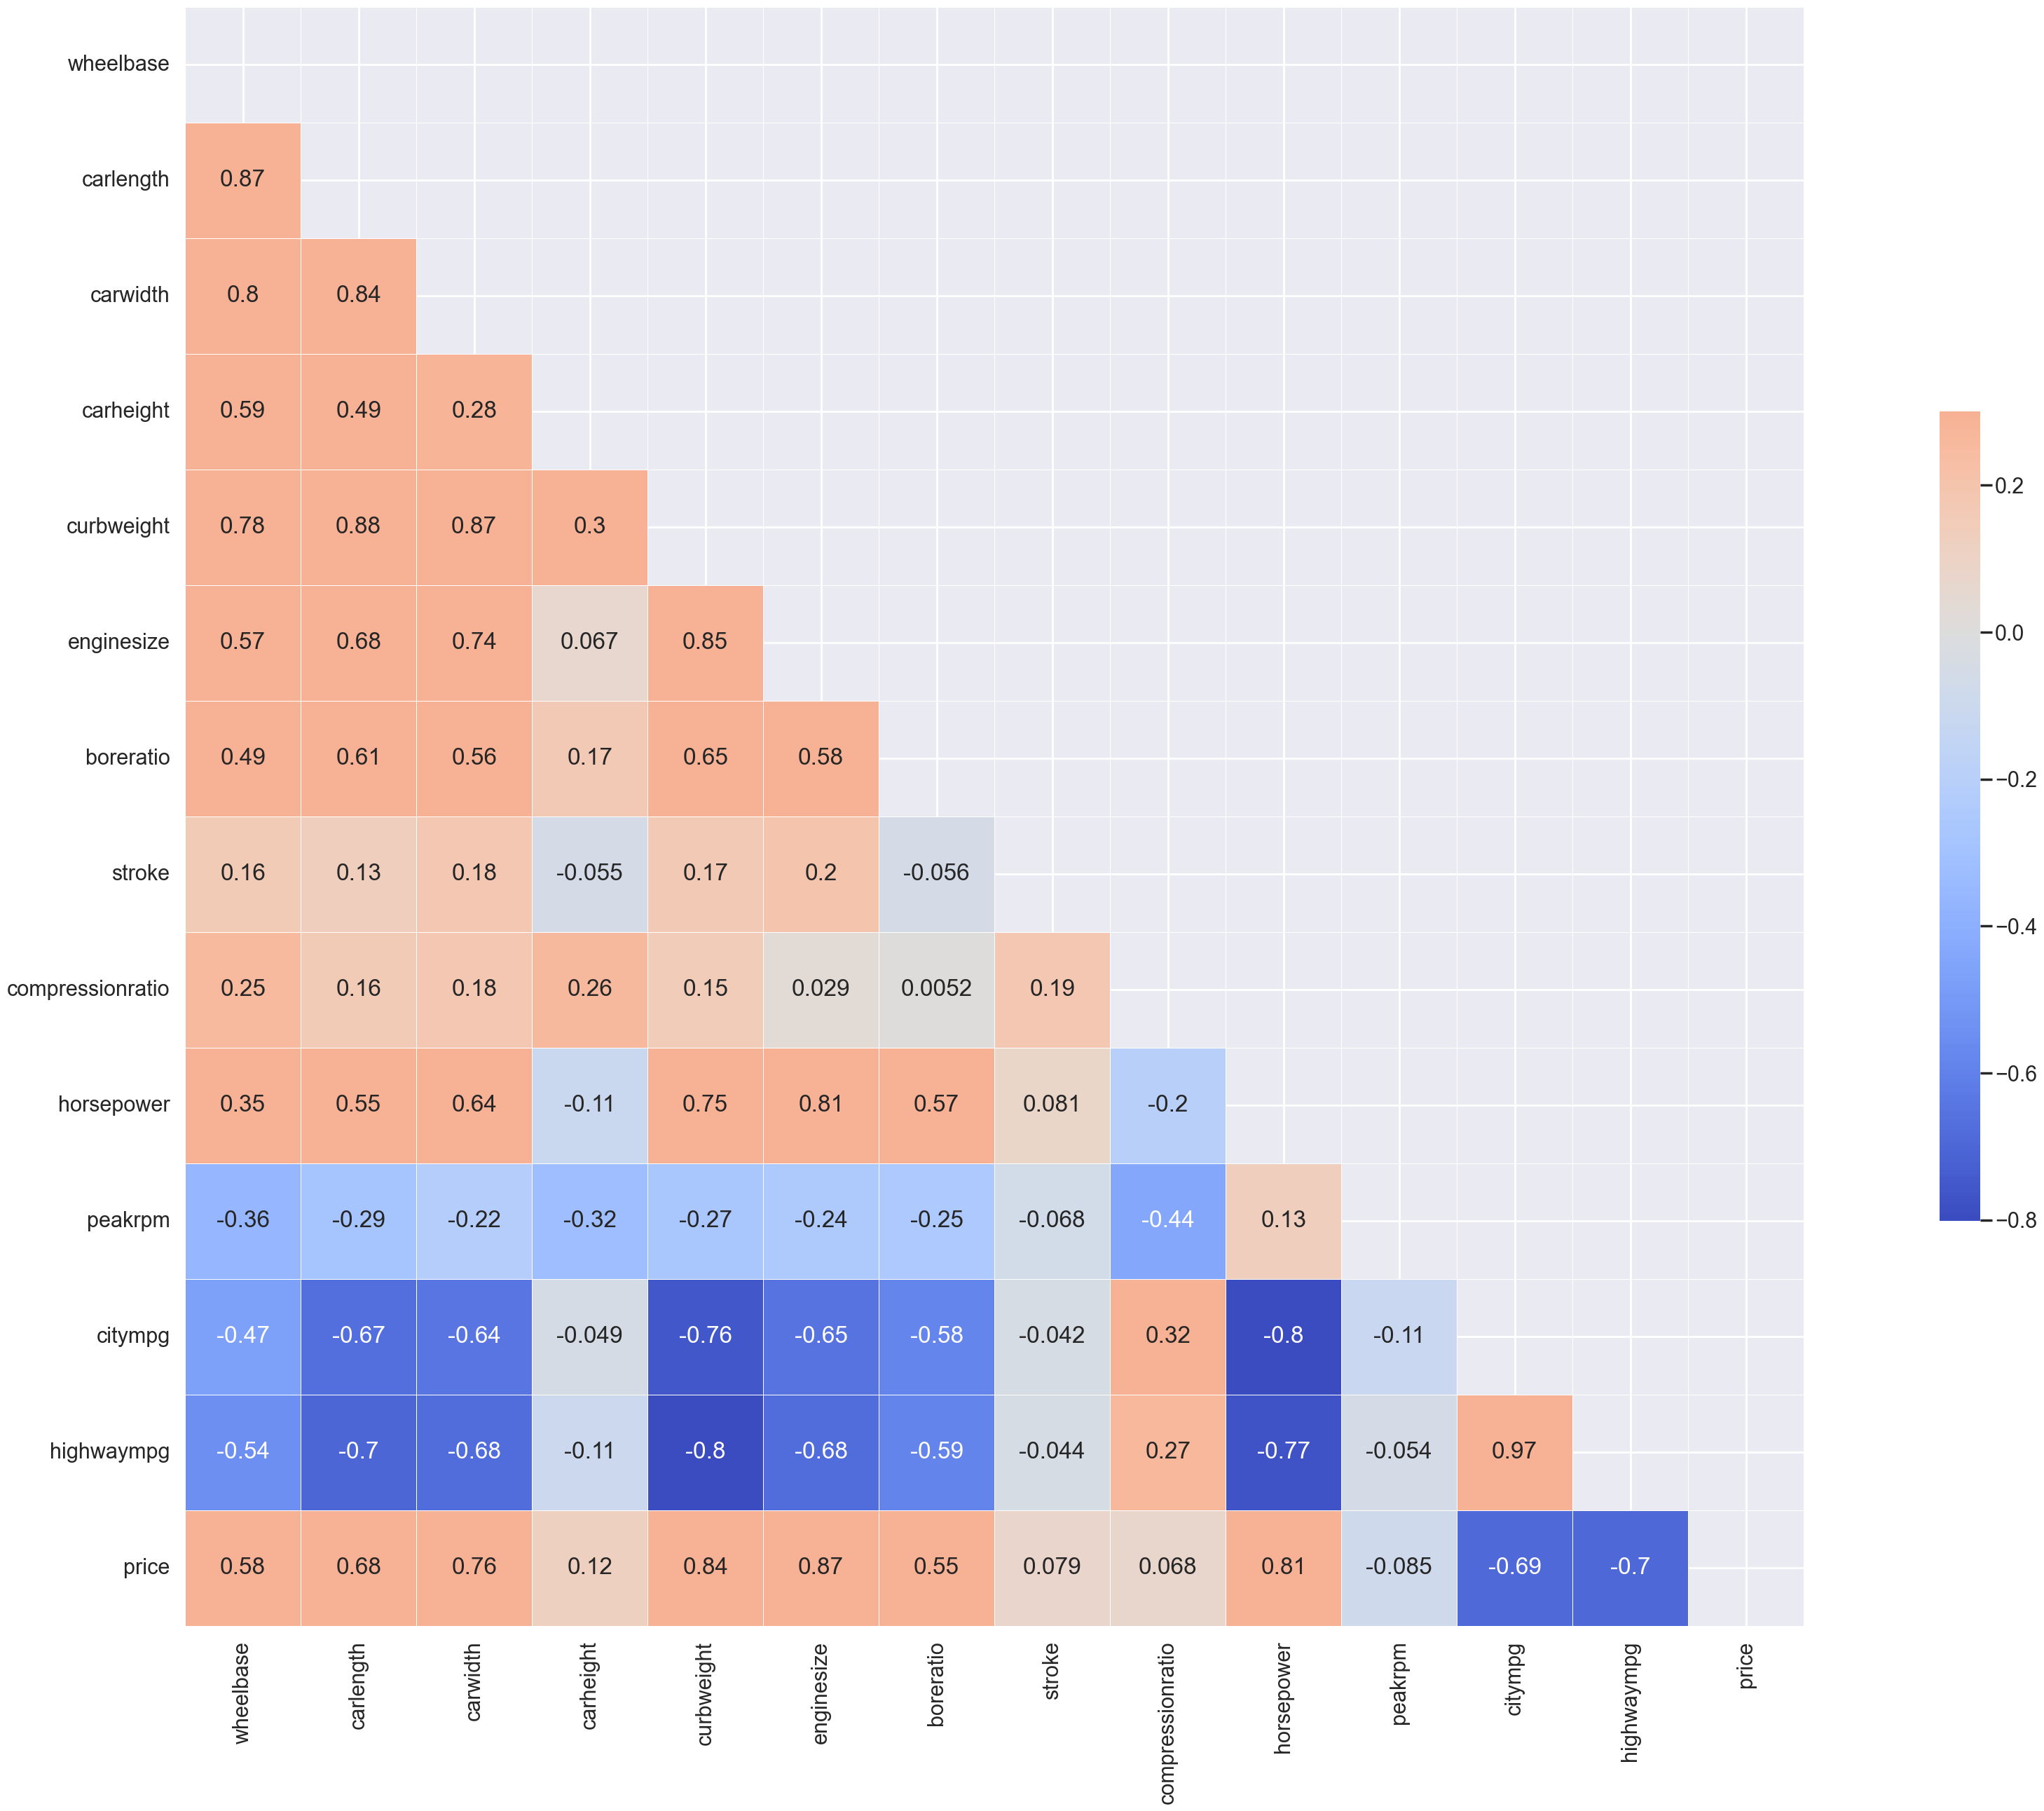

   car_ID  symboling fueltype aspiration doornumber      carbody drivewheel   
0       1          3      gas        std        two  convertible        rwd  \
1       2          3      gas        std        two  convertible        rwd   
2       3          1      gas        std        two    hatchback        rwd   
3       4          2      gas        std       four        sedan        fwd   
4       5          2      gas        std       four        sedan        4wd   

  enginelocation  carheight enginetype  ... fuelsystem boreratio  stroke   
0          front       48.8       dohc  ...       mpfi      3.47    2.68  \
1          front       48.8       dohc  ...       mpfi      3.47    2.68   
2          front       52.4       ohcv  ...       mpfi      2.68    3.47   
3          front       54.3        ohc  ...       mpfi      3.19    3.40   
4          front       54.3        ohc  ...       mpfi      3.19    3.40   

   compressionratio  peakrpm    price  CompanyName     carsize   
0 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.135e+07, tolerance: 9.496e+05
  model = cd_fast.enet_coordinate_descent(


Lasso Training RMSE: 1316.3533114017325
Lasso Testing RMSE: 2792.0548195497395
Ridge Training RMSE: 1317.0439665063027
Ridge Testing RMSE: 2761.285530421633
Adjusted_r_squared: 1.3380764101537825
MAPE: 14.365956033196184 %


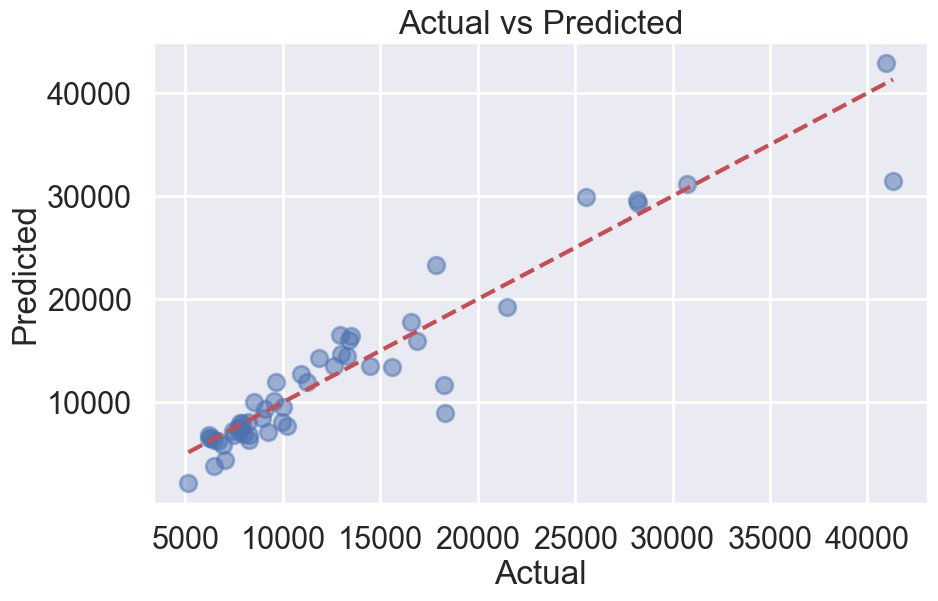

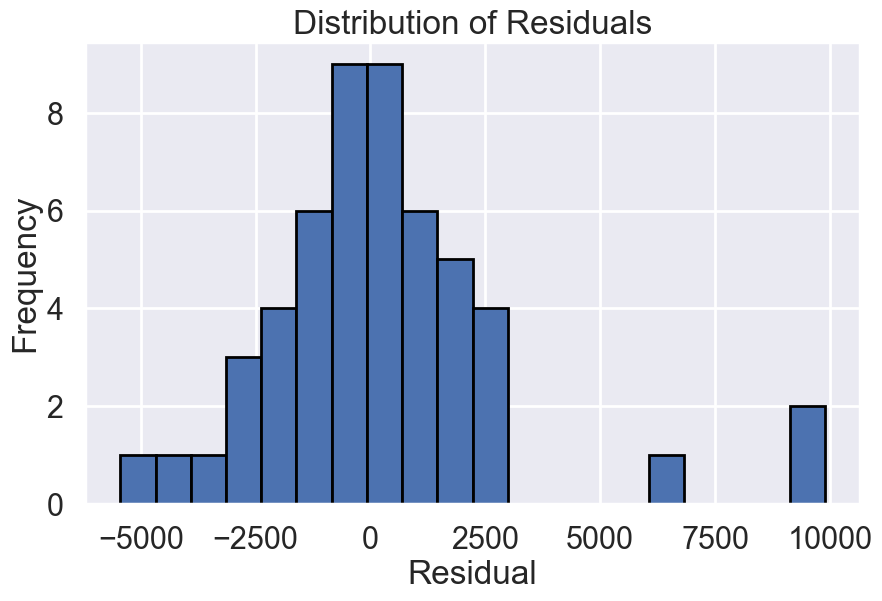

In [2]:
%run ./Capstone_2nd_Preprocessing_and_training_notebook.ipynb

Modeling

The objective of this project is to build models to predict the price of car as a function of features that define a car and and to study how the variation of the different features affect the price of the car

The purpose of this notebook is to use additional algorithms to model the relationship between features and car price then comparison their performance.

Table of Contents

[e.1 Random Forests](#e.1)

[e.2 XGBoost](#e.2)

[e.3 LightGBM](#e.3)

[e.4 Residual Histogram](#e.4)

[e.5 SHAP](#e.5)

<a id="e.1"></a>
## e.1 Random Forests

In [3]:
#Random Forests

from sklearn.ensemble import RandomForestRegressor

# Create the models
random_forest_model = RandomForestRegressor(random_state=42)

# Train the models
random_forest_model.fit(X_train_scaled, y_train)

# Make predictions using the test set
preds = random_forest_model.predict(X_test_scaled)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))



RMSE: 2276.101159


<a id="e.2"></a>
## e.2 XGBoost

In [4]:
#XGBoost

import xgboost as xgb

# Initialize XGBoost model
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

# Fit the model
xg_reg.fit(X_train_scaled, y_train)

# Predict
preds = xg_reg.predict(X_test_scaled)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 6748.692428


<a id="e.3"></a>
## e.3 LightGBM

In [5]:
#LighGBM

import lightgbm as lgb

# Initialize LGBM model
lgb_reg = lgb.LGBMRegressor(objective='regression', learning_rate=0.1, n_estimators=100)

# Fit the model
lgb_reg.fit(X_train_scaled, y_train, eval_set=[(X_test_scaled, y_test)], eval_metric='l1', early_stopping_rounds=5)

# Predict
preds = lgb_reg.predict(X_test_scaled)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

[1]	valid_0's l1: 5571.27	valid_0's l2: 5.84483e+07
[2]	valid_0's l1: 5162.77	valid_0's l2: 5.08989e+07
[3]	valid_0's l1: 4838.76	valid_0's l2: 4.55141e+07
[4]	valid_0's l1: 4575.29	valid_0's l2: 4.11021e+07
[5]	valid_0's l1: 4362	valid_0's l2: 3.7754e+07
[6]	valid_0's l1: 4148.05	valid_0's l2: 3.47738e+07
[7]	valid_0's l1: 3952.7	valid_0's l2: 3.24457e+07
[8]	valid_0's l1: 3801.27	valid_0's l2: 3.06322e+07
[9]	valid_0's l1: 3636.69	valid_0's l2: 2.88523e+07
[10]	valid_0's l1: 3471.53	valid_0's l2: 2.69673e+07
[11]	valid_0's l1: 3327.51	valid_0's l2: 2.53202e+07
[12]	valid_0's l1: 3210.69	valid_0's l2: 2.3931e+07
[13]	valid_0's l1: 3072.03	valid_0's l2: 2.24798e+07
[14]	valid_0's l1: 3005.41	valid_0's l2: 2.18244e+07
[15]	valid_0's l1: 2924.05	valid_0's l2: 2.09503e+07
[16]	valid_0's l1: 2838.86	valid_0's l2: 2.00358e+07
[17]	valid_0's l1: 2782.69	valid_0's l2: 1.93897e+07
[18]	valid_0's l1: 2715.08	valid_0's l2: 1.83614e+07
[19]	valid_0's l1: 2635.88	valid_0's l2: 1.7612e+07
[20]	vali

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


<a id="e.4"></a>
## e.4 Residual Histogram

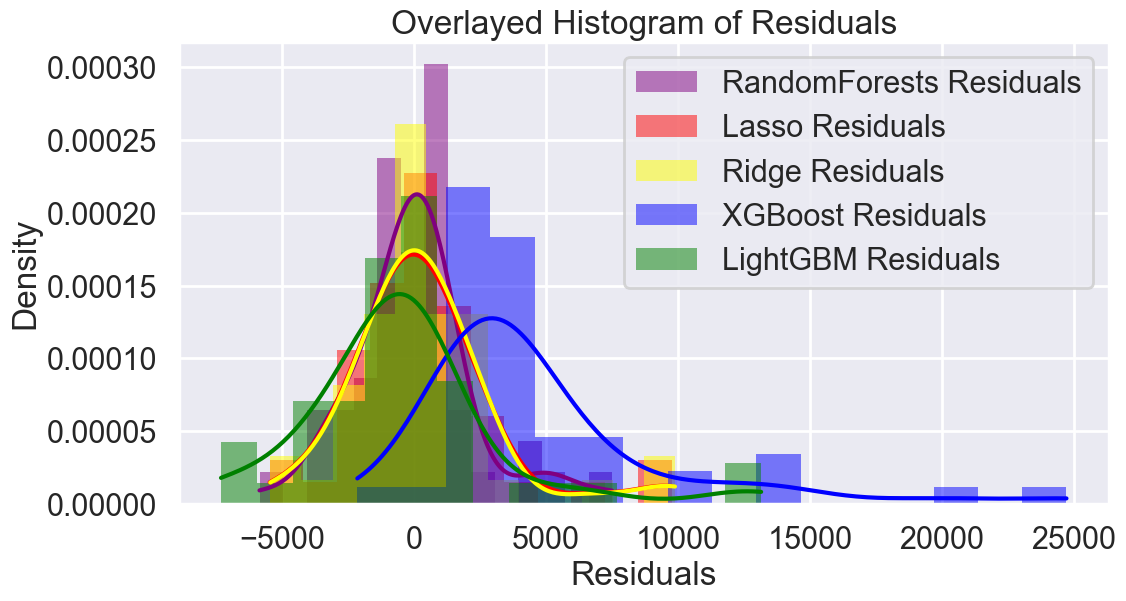

In [6]:
import seaborn as sns

# Calculate residuals
residuals_randomforests = y_test - random_forest_model.predict(X_test_scaled)
residuals_lasso = y_test - lasso_model.predict(X_test_scaled)
residuals_ridge = y_test - ridge_model.predict(X_test_scaled)
residuals_xgb = y_test - xg_reg.predict(X_test_scaled)  # from XGBoost
residuals_lgbm = y_test - lgb_reg.predict(X_test_scaled)  # from LightGBM

# Set up the matplotlib figure
plt.figure(figsize=(12, 6))

# Plot histogram of residuals for each model
sns.histplot(residuals_randomforests, color="purple", label="RandomForests Residuals", kde=True, stat="density", linewidth=0)
sns.histplot(residuals_lasso, color="red", label="Lasso Residuals", kde=True, stat="density", linewidth=0)
sns.histplot(residuals_ridge, color="yellow", label="Ridge Residuals", kde=True, stat="density", linewidth=0)
sns.histplot(residuals_xgb, color="blue", label="XGBoost Residuals", kde=True, stat="density", linewidth=0)
sns.histplot(residuals_lgbm, color="green", label="LightGBM Residuals", kde=True, stat="density", linewidth=0)

# Plot formatting
plt.title('Overlayed Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.legend()

plt.show()

The RandomForests model histogram shows the smallest spread of residuals and tallest peak. It also centers around zero. The XGBoost model histgram shows the wider spread of residuals and it does not center around zero. The Lassso and Ridge models show similar performance. Therefore, Randomforests model is the best choice. 

<a id="e.5"></a>
## e.5 SHAP

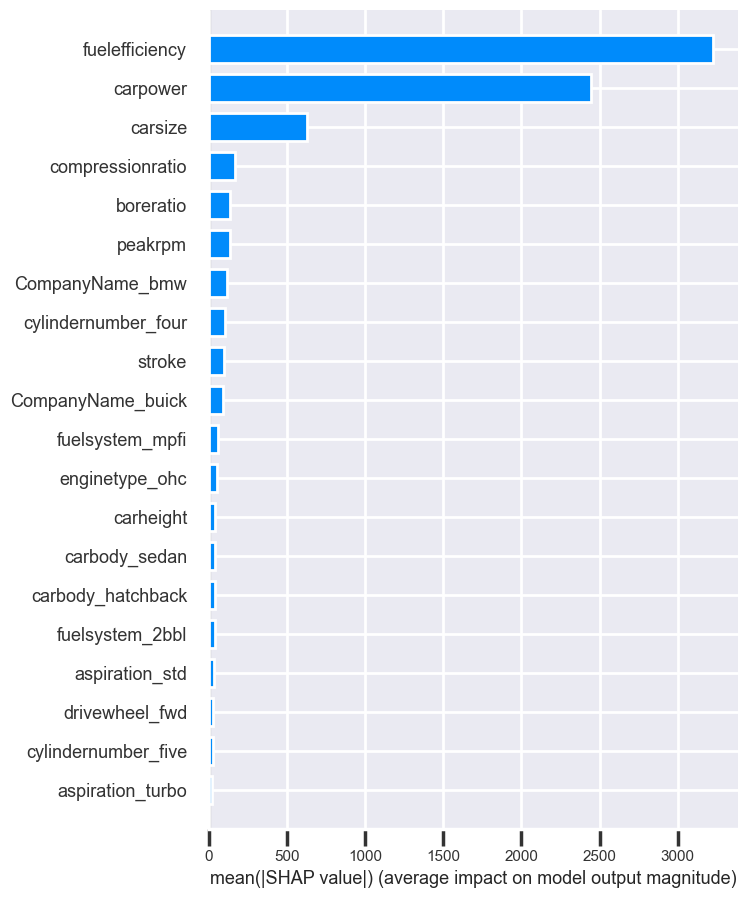

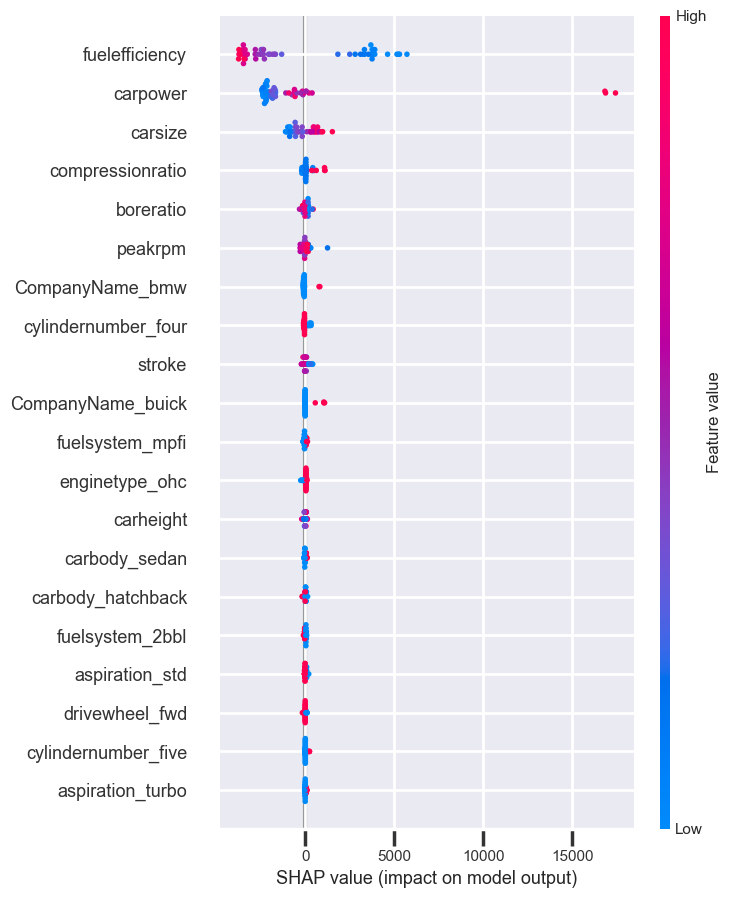

In [7]:
#SHAP

import shap

%matplotlib inline


# Initialize SHAP explainer
explainer = shap.Explainer(random_forest_model, X_train_scaled)

# Assuming you have the original column names available
column_names = X.columns  # X being the original unscaled DataFrame

# Convert the numpy array back to pandas DataFrame
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=column_names)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test_scaled_df)


# Visualize the SHAP summary plot
shap.summary_plot(shap_values, X_test_scaled_df, plot_type="bar")


# Visualize detailed SHAP summary plot
shap.summary_plot(shap_values, X_test_scaled_df)




From the SHAP summary plot, fuelefficiency, carpower, and carsize are the top three features that impact car price. 

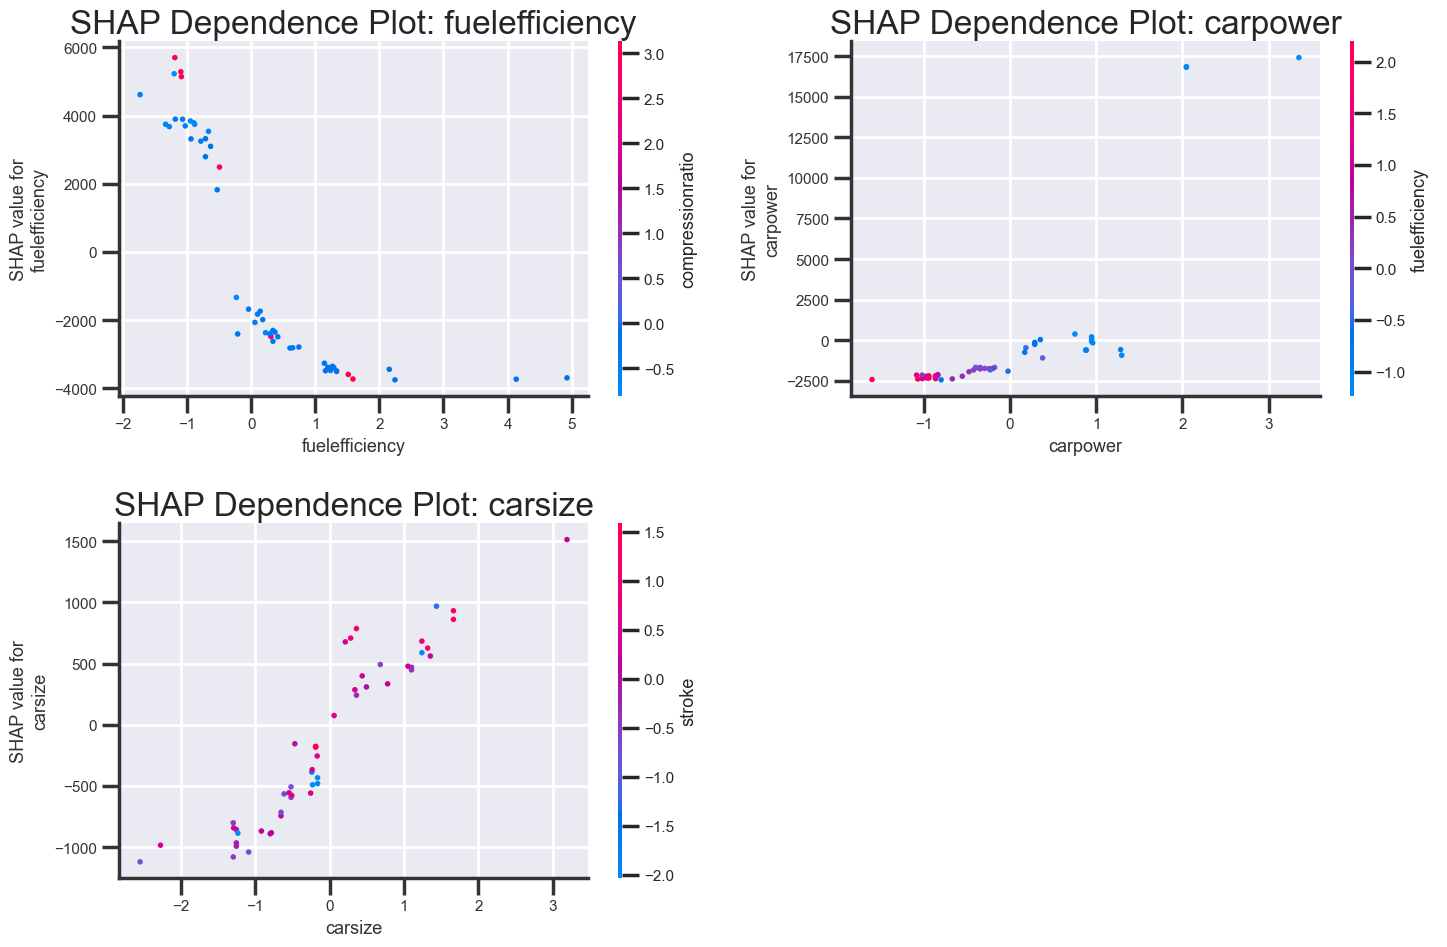

In [8]:

# Initialize SHAP explainer
explainer = shap.Explainer(random_forest_model, X_train_scaled)

# Convert the numpy array back to pandas DataFrame
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=column_names)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test_scaled_df)

# Define the features of interest
features_of_interest = ['fuelefficiency', 'carpower', 'carsize']

# Set up a 2x2 subplot
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.flatten()  # Flatten to 1D array for easy iteration

# Plot SHAP dependence plots for each feature
for i, feature in enumerate(features_of_interest):
    shap.dependence_plot(feature, shap_values, X_test_scaled_df, ax=axs[i], show=False)
    axs[i].set_title(f'SHAP Dependence Plot: {feature}')

# Hide the last subplot (empty)
axs[-1].axis('off')

plt.tight_layout()
plt.show()


From the fuelefficiency dependence plot, generally speaking, lower fule efficiency contributes to a higher price prediction. High fuel efficiency contributs to a lower price prediction. From the carpower dependence plot, lower carpower (less than zero) contributes to a lower price prediction. Higher carpower (more than zero) has averagely small contribution to price prediction. Lower carpower tends to have higher fuel efficiency. Higher carpower tends to have lower fuel efficiency. From the carsize dependence plot, smaller carsize contributes to a lower price prediction. Larger carsize contributes to a higher price prediction.

Summary
Among all models, RandomForests model has the smallest RMSE of 2276. The associated histogram of residule also indicates that this model performs the best compared to other models. The SHAP summary plot indicates that the top features that affect car price include fuel efficiency, car power, and car size. While fuel efficiency has a negative impact on car price, which means that higher fuel effiiency car sells for lower price, car size has a positive impact on car price, which means that bigger car sells for higher price. 